<a href="https://colab.research.google.com/github/ryanott20/wrangling/blob/main/LabRV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import requests # Page requests

header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0'} # How we wish to appear to CL
url = 'https://charlottesville.craigslist.org/search/rva?postal=22903&search_distance=100#search=2~gallery~0' # The page we want to scrape
raw = requests.get(url,headers=header) # Get page

In [59]:
from bs4 import BeautifulSoup as soup # HTML parser
bsObj = soup(raw.content,'html.parser') # Parse the html
listings = bsObj.find_all(class_="cl-static-search-result") # Find all listings of the kind we want

In [60]:
import re # Regular expressions

rv_brands = ['winnebago', 'airstream', 'forest river', 'jayco', 'keystone', 'thor',
             'coachmen', 'dutchmen', 'heartland', 'grand design', 'newmar', 'tiffin',
             'fleetwood', 'gulfstream', 'roadtrek', 'entegra', 'monaco', 'beaver',
             'holiday rambler', 'sunseeker', 'chateau', 'tioga', 'vista', 'pursuit']

data = [] # We'll save our listings in this object
for k in range( len(listings) ):
    title = listings[k].find('div',class_='title').get_text().lower()
    price = listings[k].find('div',class_='price').get_text()
    link = listings[k].find(href=True)['href']
    # Get brand from the title string:
    words = title.split()
    hits = [word for word in words if word in rv_brands] # Find single-word brands in the title
    # Also check for multi-word brands in the full title:
    for brand in rv_brands:
        if brand in title and brand not in hits:
            hits.append(brand)
    if len(hits) == 0:
        brand = 'missing'
    else:
        brand = hits[0]
    # Get years from title string:
    regex_search = re.search(r'20[0-9][0-9]|19[0-9][0-9]', title ) # Find year references
    if regex_search is None: # If no hits, record year as missing value
        year = np.nan
    else: # If hits, record year as first match
        year = regex_search.group(0)
    #
    data.append({'title':title,'price':price,'year':year,'link':link,'brand':brand})

In [61]:
## Wrangle the data
df = pd.DataFrame.from_dict(data)
df['price'] = df['price'].str.replace('$','')
df['price'] = df['price'].str.replace(',','')
df['price'] = pd.to_numeric(df['price'],errors='coerce')
df['year'] = pd.to_numeric(df['year'],errors='coerce')
df['age'] = 2025-df['year']
print(df.shape)
df.to_csv('craigslist_cville_rvs.csv') # Save data in case of a disaster
df.head()

(59, 6)


,title,price,year,link,brand,age
0,east to west della terra,17500,NaN,https://fredericksburg.craigslist.org/rvs/d/fr...,missing,NaN
1,2020 thor majestic 23a class c rv 25 footer,32850,2020.0,https://winchester.craigslist.org/rvd/d/winche...,thor,5.0
2,2007 dutchmen four winds lite 28r-gs travel tr...,8000,2007.0,https://charlottesville.craigslist.org/rvs/d/w...,dutchmen,18.0
3,🚐 rvs • trailers • campervans • by the day or ...,0,NaN,https://richmond.craigslist.org/rvd/d/richmond...,missing,NaN
4,2015 casita spirit deluxe 17',20000,2015.0,https://charlottesville.craigslist.org/rvs/d/l...,missing,10.0


count        59.000000
mean      34395.508475
std       38379.147515
min           0.000000
25%       18000.000000
50%       29850.000000
75%       33995.000000
max      235000.000000
Name: price, dtype: float64


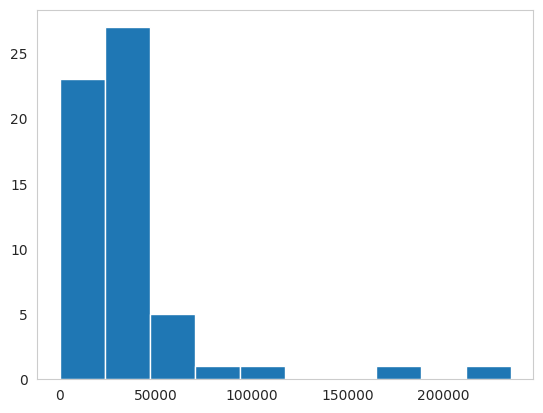

count    51.000000
mean      6.156863
std       5.981212
min      -1.000000
25%       3.000000
50%       5.000000
75%       8.000000
max      26.000000
Name: age, dtype: float64


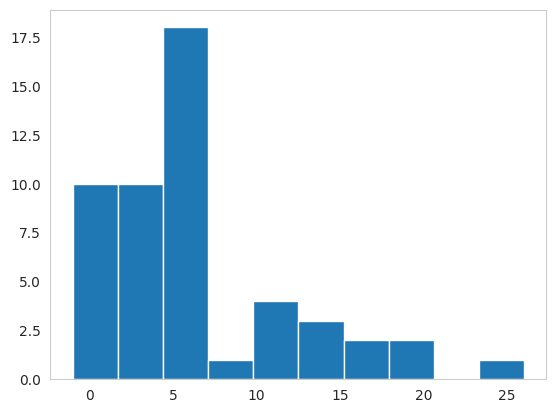

In [62]:
print(df['price'].describe())
df['price'].hist(grid=False)
plt.show()
print(df['age'].describe())
df['age'].hist(grid=False)
plt.show()


In [63]:
df.loc[:,['price','brand']].groupby('brand').describe()


price                                                  \
                count           mean            std      min      25%   
brand                                                                   
airstream         1.0   62500.000000            NaN  62500.0  62500.0   
dutchmen          1.0    8000.000000            NaN   8000.0   8000.0   
forest river      4.0   24746.000000   11235.776371   9995.0  18998.0   
grand design      1.0   18500.000000            NaN  18500.0  18500.0   
holiday rambler   1.0   30557.000000            NaN  30557.0  30557.0   
keystone          5.0   25669.000000   17016.717662   2950.0  19995.0   
missing          39.0   31425.641026   32007.475323      0.0  16500.0   
newmar            2.0  131500.000000  146371.103706  28000.0  79750.0   
sunseeker         1.0   15000.000000            NaN  15000.0  15000.0   
thor              3.0   39616.666667   18929.892586  25000.0  28925.0   
tiffin            1.0   59999.000000            NaN  59999.0  59999.0   

                                               
                      50%       75%       max  
brand                                          
airstream         62500.0   62500.0   62500.0  
dutchmen           8000.0    8000.0    8000.0  
forest river      27497.0   33245.0   33995.0  
grand design      18500.0   18500.0   18500.0  
holiday rambler   30557.0   30557.0   30557.0  
keystone          25500.0   29900.0   50000.0  
missing           29850.0   33495.0  176500.0  
newmar           131500.0  183250.0  235000.0  
sunseeker         15000.0   15000.0   15000.0  
thor              32850.0   46925.0   61000.0  
tiffin            59999.0   59999.0   59999.0

In [64]:
df.loc[:,['age','brand']].groupby('brand').describe()

age                                                    
                count       mean        std   min   25%   50%   75%   max
brand                                                                    
airstream         1.0   6.000000        NaN   6.0   6.0   6.0   6.0   6.0
dutchmen          1.0  18.000000        NaN  18.0  18.0  18.0  18.0  18.0
forest river      4.0   1.000000   2.309401  -1.0  -1.0   1.0   3.0   3.0
grand design      1.0   7.000000        NaN   7.0   7.0   7.0   7.0   7.0
holiday rambler   1.0  19.000000        NaN  19.0  19.0  19.0  19.0  19.0
keystone          4.0   9.500000   5.972158   3.0   6.0   9.0  12.5  17.0
missing          32.0   4.625000   4.640286  -1.0   1.5   5.0   6.0  17.0
newmar            2.0  16.000000  14.142136   6.0  11.0  16.0  21.0  26.0
sunseeker         1.0   6.000000        NaN   6.0   6.0   6.0   6.0   6.0
thor              3.0   7.666667   3.055050   5.0   6.0   7.0   9.0  11.0
tiffin            1.0  13.000000        NaN  13.0  13.0  13.0  13.0  13.0

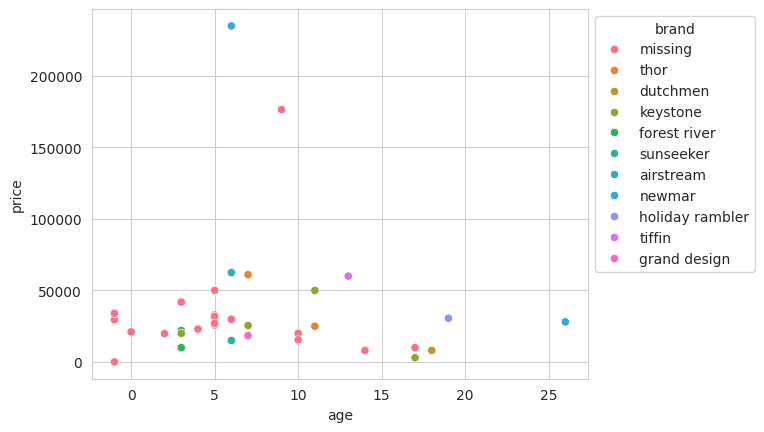

In [65]:
ax = sns.scatterplot(data=df, x='age', y='price',hue='brand')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


           log_price   log_age
log_price   0.565695 -0.138506
log_age    -0.138506  0.391553
           log_price   log_age
log_price   1.000000 -0.282517
log_age    -0.282517  1.000000


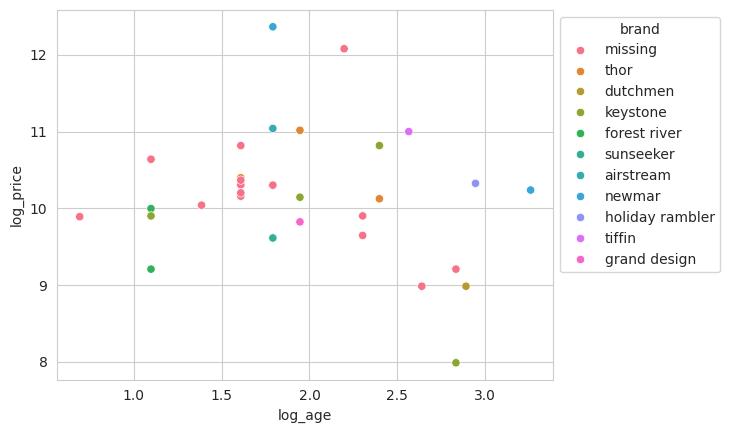

In [66]:
df['log_price'] = np.log(df['price'])
df['log_age'] = np.log(df['age'])

ax = sns.scatterplot(data=df, x='log_age', y='log_price',hue='brand')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

print(df.loc[:,['log_price','log_age']].cov())
print(df.loc[:,['log_price','log_age']].corr())